In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import shap

In [ ]:
def load_data(file_path: str):
    df = pd.read_csv(file_path, sep=';')
    return df

#### Logistic Regression

In [ ]:
def lr_preprocess_data(df: pd.DataFrame):
    """
    Preprocesses a DataFrame for training a Logistic Regression model by encoding the target,
    dropping leakage-prone features, and creating a preprocessing pipeline.

    Parameters:
    - df: Input DataFrame containing features and the target column 'y'

    Returns:
    - df: Cleaned feature DataFrame
        - Filters out rows where 'duration' == 0
        - Drops the 'duration' column to prevent data leakage
    - y: Binary-encoded target series (1 for 'yes', 0 for 'no')
    - preprocessor: ColumnTransformer pipeline that applies:
        - StandardScaler to numerical columns
        - OneHotEncoder (with unknown category handling) to categorical columns
    """
    df = df.copy()
    # Remove cero time calls for noise reduction
    df = df[df['duration'] > 0]  
    y = df.pop('y').map({'yes': 1, 'no': 0})

    # Drop duration feature to avoid leakage
    if 'duration' in df.columns:
        df.drop(columns='duration', inplace=True)

    categorical_cols = df.select_dtypes(include='object').columns.tolist()
    numerical_cols = df.select_dtypes(include='number').columns.tolist()

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

    return df, y, preprocessor

In [ ]:
def lr_train_model(X, y, preprocessor):
    """
    Trains a Logistic Regression model using a preprocessing pipeline and evaluates its performance on a test set.

    Parameters:
    - X: Feature matrix (raw input features before preprocessing)
    - y: Target vector (binary classification)
    - preprocessor: Preprocessing pipeline (e.g., ColumnTransformer) to be applied before model training

    Returns:
    - model: Trained scikit-learn Pipeline (preprocessor + logistic regression classifier)
    - X_test: Test feature matrix (raw, unprocessed — suitable for downstream explanation functions)
    - y_test: True labels for the test set

    Additional Output:
    - Prints classification metrics (precision, recall, f1-score) and a confusion matrix for test predictions.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("\nModel Performance:\n")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    return model, X_test, y_test

In [ ]:
def lr_explain_model(model, X_test):
    """
    Generates a SHAP summary bar plot to explain a linear model's feature importance.

    Parameters:
    - model: Trained scikit-learn Pipeline containing a 'preprocessor' step and a 'classifier' (e.g., LogisticRegression)
    - X_test: Raw test feature DataFrame (before preprocessing)

    Returns:
    - A SHAP bar plot showing the mean absolute SHAP value of each feature,
      indicating its overall importance to the model's predictions.
      
    Notes:
    - The function transforms the input features using the pipeline's preprocessor.
    - Feature names are extracted from the preprocessor using get_feature_names_out().
    """
    explainer = shap.Explainer(model.named_steps['classifier'], model.named_steps['preprocessor'].transform(X_test))
    shap_values = explainer(model.named_steps['preprocessor'].transform(X_test))

    shap.summary_plot(shap_values, features=model.named_steps['preprocessor'].transform(X_test), feature_names=model.named_steps['preprocessor'].get_feature_names_out(), plot_type="bar")


Model Performance:

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7984
           1       0.68      0.18      0.28      1058

    accuracy                           0.89      9042
   macro avg       0.79      0.58      0.61      9042
weighted avg       0.87      0.89      0.87      9042

Confusion Matrix:
 [[7895   89]
 [ 871  187]]


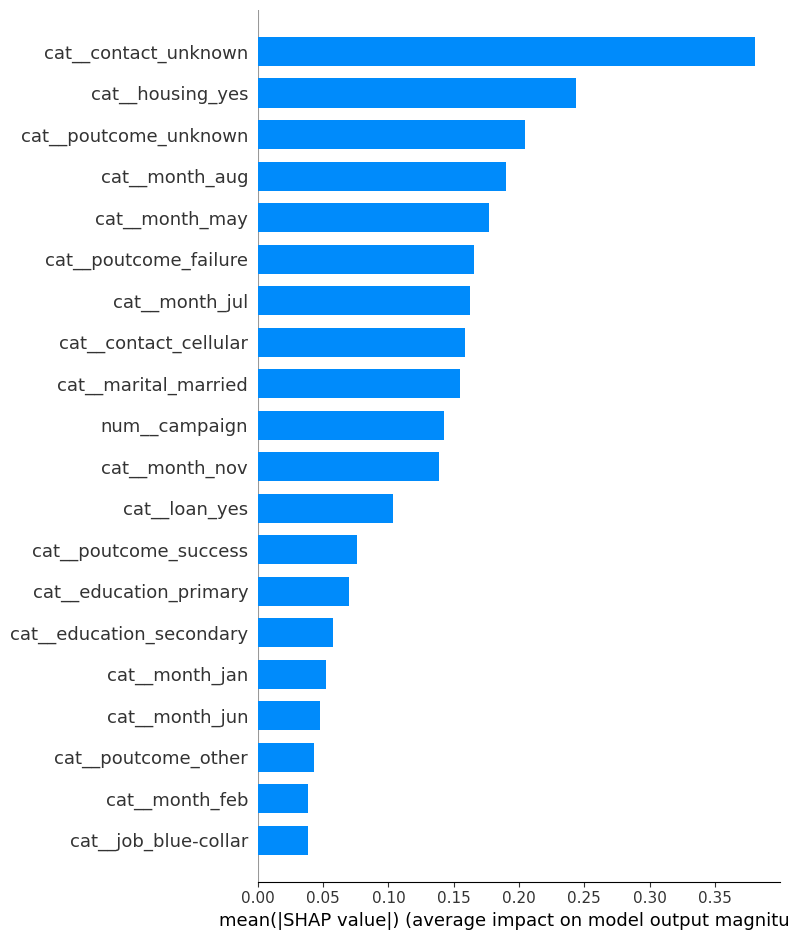

In [ ]:
df = load_data('../data_input/bank-full.csv')
X, y, preprocessor = lr_preprocess_data(df)
model, X_test, y_test = lr_train_model(X, y, preprocessor)
lr_explain_model(model, X_test)

#### Extreme Gradient Boosting

In [ ]:
def xgb_preprocess_data(df: pd.DataFrame):
    """
    Preprocesses a DataFrame for XGBoost training by handling target encoding, feature cleanup,
    and categorical type conversion.

    Parameters:
    - df: Input DataFrame containing features and the target column 'y'

    Returns:
    - df: Preprocessed feature DataFrame
        - Filters out rows where 'duration' == 0
        - Drops the 'duration' column to prevent data leakage
        - Converts object-type columns to 'category' dtype for XGBoost compatibility
    - y: Binary-encoded target series (1 for 'yes', 0 for 'no')
    """
    df = df.copy()
    # Remove cero time calls for noise reduction
    df = df[df['duration'] > 0]  
    y = df.pop('y').map({'yes': 1, 'no': 0})

    # Drop duration feature to avoid leakage
    if 'duration' in df.columns:
        df.drop(columns='duration', inplace=True)

    categorical_cols = df.select_dtypes(include='object').columns.tolist()

    for colname in categorical_cols:
        df[colname] = df[colname].astype('category')

    return df, y

In [ ]:
def xgb_train_model(X, y):
    """
    Trains an XGBoost classification model and evaluates its performance on a test set.

    Parameters:
    - X: Feature matrix (numeric and categorical)
    - y: Target vector (binary classification)

    Returns:
    - model: Trained XGBoost classifier
    - X_test: Test feature matrix (for further evaluation and explanation)
    - y_test: True labels for the test set

    Additional Output:
    - Prints a classification report (precision, recall, f1-score) and a confusion matrix for test predictions.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    model = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2, enable_categorical=True)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    y_pred = model.predict(X_test)

    print("\nModel Performance:\n")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    return model, X_test, y_test

In [ ]:
def xgb_explain_model(model, X):
    """
    Generates and saves a SHAP beeswarm plot to explain feature importance for the XGBoost model.

    Parameters:
    - model: Trained XGBoost model (xgb.XGBClassifier)
    - X: Feature matrix (same format used during training)

    Returns:
    - feature_importance: List of feature names ordered by their mean absolute SHAP value (descending)

    Additional Output:
    - A SHAP beeswarm plot showing the SHAP value of each feature, indicating its overall importance to the model's predictions.
    """
    explainer = shap.TreeExplainer(model)
    explanation = explainer(X)

    shap.plots.beeswarm(explanation)

    # Get mean absolute SHAP values and sort features
    shap_values = np.abs(explanation.values).mean(axis=0)
    feature_names = explanation.feature_names
    feature_importance = sorted(zip(feature_names, shap_values), key=lambda x: x[1], reverse=True)

    # Return ordered list of feature names
    return [f for f, _ in feature_importance]

[0]	validation_0-logloss:0.32078
[1]	validation_0-logloss:0.30575
[2]	validation_0-logloss:0.29693
[3]	validation_0-logloss:0.29247
[4]	validation_0-logloss:0.28938
[5]	validation_0-logloss:0.28717
[6]	validation_0-logloss:0.28592
[7]	validation_0-logloss:0.28511
[8]	validation_0-logloss:0.28408
[9]	validation_0-logloss:0.28341
[10]	validation_0-logloss:0.28253
[11]	validation_0-logloss:0.28285

Model Performance:

              precision    recall  f1-score   support

           0       0.91      0.99      0.94      7984
           1       0.67      0.22      0.33      1058

    accuracy                           0.90      9042
   macro avg       0.79      0.60      0.64      9042
weighted avg       0.88      0.90      0.87      9042

Confusion Matrix:
 [[7866  118]
 [ 822  236]]


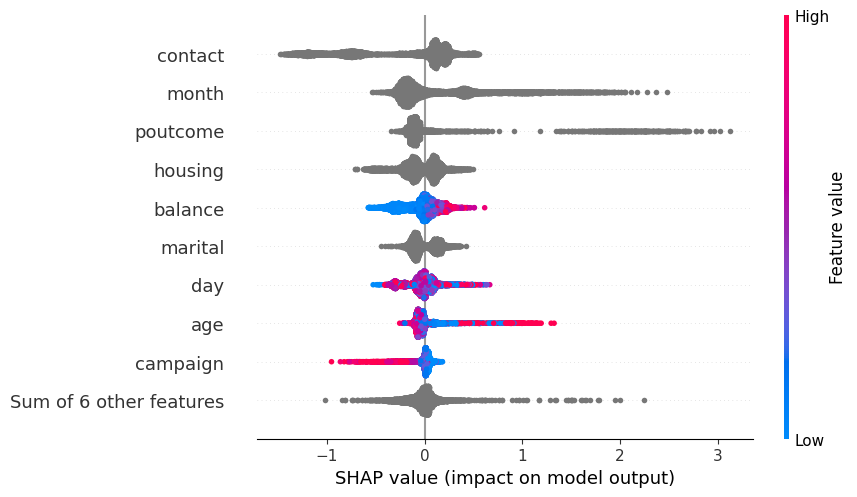

['contact', 'month', 'poutcome', 'housing', 'balance', 'marital', 'day', 'age', 'campaign', 'job', 'loan', 'pdays', 'education', 'previous', 'default']


In [78]:
df = load_data('../data_input/bank-full.csv')
X, y = xgb_preprocess_data(df)
model, X_test, y_test = xgb_train_model(X, y)
xgb_explain_model(model, X_test)

In [ ]:
def categorical_summary(df: pd.DataFrame, feature: str, target: str):
    grouped = df.groupby(feature)[target].value_counts().unstack(fill_value=0)

    grouped.columns = grouped.columns.astype(str)
    grouped['N_total'] = grouped.sum(axis=1)
    grouped['N_yes'] = grouped.get('yes', 0)
    grouped['N_no'] = grouped.get('no', 0)

    grouped['pct_yes_total'] = grouped['N_yes'] / grouped['N_total']
    grouped['pct_yes_no'] = grouped.apply(lambda row: row['N_yes'] / row['N_no'] if row['N_no'] > 0 else None, axis=1)

    return grouped[['N_total', 'N_yes', 'N_no', 'pct_yes_total', 'pct_yes_no']].sort_values('pct_yes_total', ascending=False)


In [ ]:
summary_table = categorical_summary(df, feature='contact', target='y')
print(summary_table)

y          N_total  N_yes   N_no  pct_yes_total  pct_yes_no
contact                                                    
cellular     29285   4369  24916       0.149189    0.175349
telephone     2906    390   2516       0.134205    0.155008
unknown      13020    530  12490       0.040707    0.042434


In [ ]:
summary_table = categorical_summary(df, feature='month', target='y')
print(summary_table)

y      N_total  N_yes   N_no  pct_yes_total  pct_yes_no
month                                                  
mar        477    248    229       0.519916    1.082969
dec        214    100    114       0.467290    0.877193
sep        579    269    310       0.464594    0.867742
oct        738    323    415       0.437669    0.778313
apr       2932    577   2355       0.196794    0.245011
feb       2649    441   2208       0.166478    0.199728
aug       6247    688   5559       0.110133    0.123763
jun       5341    546   4795       0.102228    0.113869
nov       3970    403   3567       0.101511    0.112980
jan       1403    142   1261       0.101212    0.112609
jul       6895    627   6268       0.090935    0.100032
may      13766    925  12841       0.067195    0.072035


In [ ]:
summary_table = categorical_summary(df, feature='poutcome', target='y')
print(summary_table)

y         N_total  N_yes   N_no  pct_yes_total  pct_yes_no
poutcome                                                  
success      1511    978    533       0.647253    1.834897
other        1840    307   1533       0.166848    0.200261
failure      4901    618   4283       0.126097    0.144291
unknown     36959   3386  33573       0.091615    0.100855
